<a href="https://colab.research.google.com/github/ykitaguchi77/Kaggle/blob/main/Bunkruptcy-prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Download Kaggle dataset**

## Google Driveのマウント

In [32]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
#Profiling用。Runtimeの再起動を要求されるので先にインポートしておく
!pip install pandas-profiling
!pip install -U pandas_profiling
!pip uninstall markupsafe
!pip install markupsafe==2.0.1 #エラー対応

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached MarkupSafe-2.1.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (25 kB)
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.0.1
    Uninstalling MarkupSafe-2.0.1:
      Successfully uninstalled MarkupSafe-2.0.1


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Found existing installation: MarkupSafe 2.1.1
Uninstalling MarkupSafe-2.1.1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/MarkupSafe-2.1.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/markupsafe/*
Proceed (y/n)? y
  Successfully uninstalled MarkupSafe-2.1.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached MarkupSafe-2.0.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (31 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires markupsafe~=2.1.1, but you have markupsafe 2.0.1 which is incompatible.


## データセットの準備
Kaggleと同じコードで動くよう、フォルダの関係を調整

In [34]:
import os
import shutil

# kaggle ライブラリのインストール
!pip install kaggle

# 一時フォルダに .kaggleフォルダを作成
!mkdir ~/.kaggle

# MyDrive の kaggle.json を一時フォルダ内の .kaggleフォルダにコピー
!cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/

# アクセス権限の設定
!chmod 600 ~/.kaggle/kaggle.json

!mkdir ~/.kaggle



os.makedirs("./input/bankruptcy-risk-prediction", exist_ok=True)
os.makedirs("./output", exist_ok=True)

# zipファイルのダウンロード
!kaggle competitions download -c bankruptcy-risk-prediction -p /content
# 解凍
!unzip ./bankruptcy-risk-prediction.zip -d ./input/bankruptcy-risk-prediction

#Zipフォルダを削除
!rm ./bankruptcy-risk-prediction.zip

#作業フォルダを作成

os.makedirs("./Kaggle", exist_ok=True)
os.chdir("./Kaggle")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/22.3k [00:00<?, ?B/s]
100% 22.3k/22.3k [00:00<00:00, 16.7MB/s]
unzip:  cannot find or open ./bankruptcy-risk-prediction.zip, ./bankruptcy-risk-prediction.zip.zip or ./bankruptcy-risk-prediction.zip.ZIP.
rm: cannot remove './bankruptcy-risk-prediction.zip': No such file or directory


In [35]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split


import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')



#**Load data**

In [36]:
# load train.csv
train_df = pd.read_csv('../input/bankruptcy-risk-prediction/train.csv')

# load test.csv
test_df = pd.read_csv('../input/bankruptcy-risk-prediction/test.csv')

# load submission_example.csv
submission = pd.read_csv('../input/bankruptcy-risk-prediction/submission_example.csv')


print(f'train_df.shape = {train_df.shape}')
print(f'test_df.shape = {test_df.shape}')
print(f'submission.shape = {submission.shape}')

pd.set_option('display.max_rows', 3)
pd.set_option('display.max_columns', 1000)

train_df

FileNotFoundError: ignored

In [ ]:
import pandas as pd
import pandas_profiling as pdp

pdp.ProfileReport(train_df)


In [ ]:
# check data type(train_data)
print(train_df.dtypes)

# check missing values (train_data)
print(train_df.isnull().sum())

# check missing values (test_data)
print(test_df.isnull().sum())

In [ ]:
# check train_data describe
train_df.describe().T

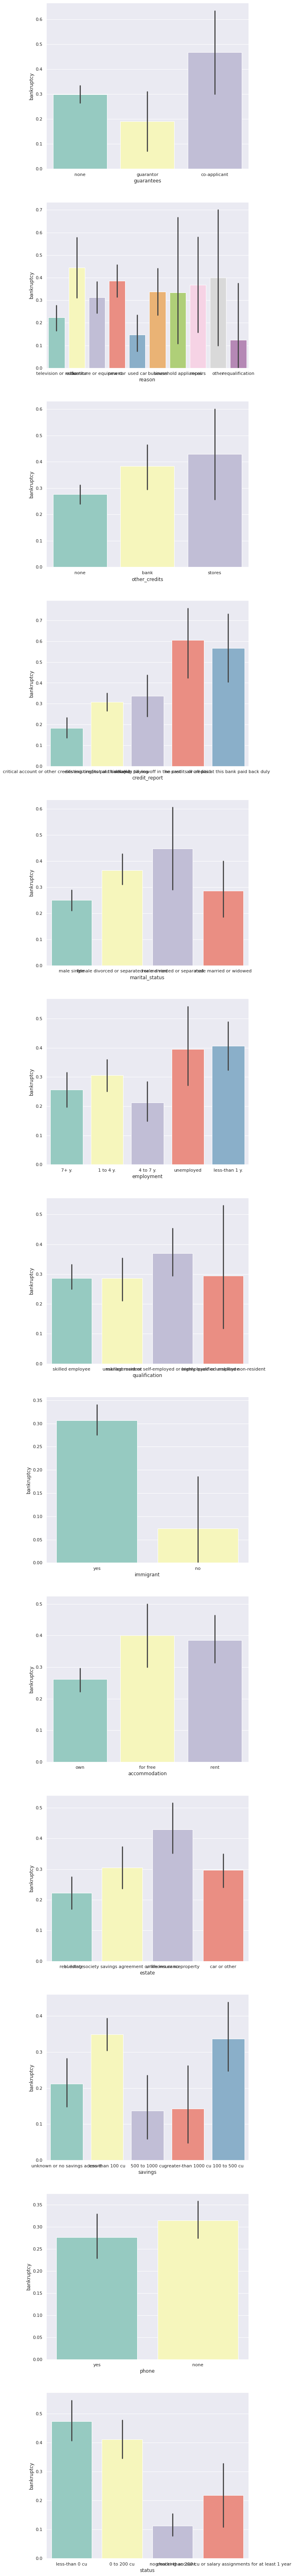

['co-applicant', 'guarantor', 'none']
['business', 'education', 'furniture or equipment', 'household appliances', 'new car', 'other', 'repairs', 'requalification', 'television or radio', 'used car']
['bank', 'none', 'stores']
['all credits at this bank paid back duly', 'critical account or other credits existing(not at this bank)', 'delay in paying off in the past', 'existing credits paid back duly till now', 'no credits or all paid']
['female divorced or separated or married', 'male divorced or separated', 'male married or widowed', 'male single']
['1 to 4 y.', '4 to 7 y.', '7+ y.', 'less-than 1 y.', 'unemployed']
['management or self-employed or highly qualified employee', 'skilled employee', 'unemployed or unskilled non-resident', 'unskilled resident']
['no', 'yes']
['for free', 'own', 'rent']
['building society savings agreement or life insurance', 'car or other', 'real estate', 'unknown or no property']
['100 to 500 cu', '500 to 1000 cu', 'greater-than 1000 cu', 'less-than 100 cu'

In [49]:
#Object項目の分布図を縦に並べて表示
import seaborn as sns
import matplotlib.pyplot as plt

categories = train_df.columns[train_df.dtypes=='object'].values.tolist()
#categories

sns.set()

fig, axes = plt.subplots(len(categories),1,figsize=(9,9*len(categories)))   

for i in range(len(categories)):
    sns.barplot(x=categories[i], y="bankruptcy", data=train_df, palette="Set3", ax=axes[i])

plt.show()


for j in range(len(categories)):
    print(train_df.groupby(categories[j]).count().index.to_list())


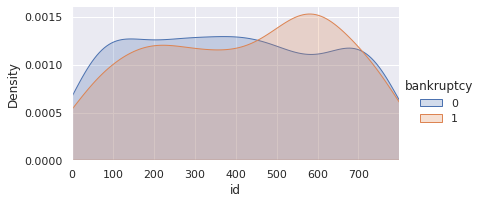

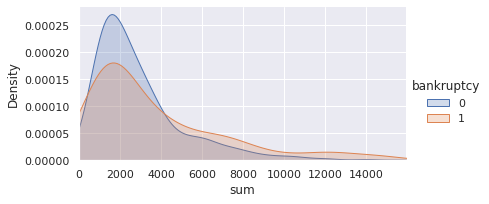

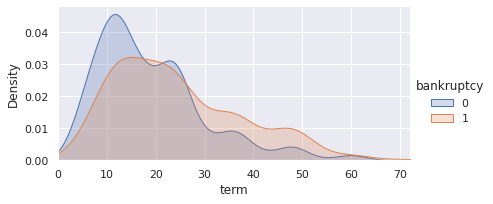

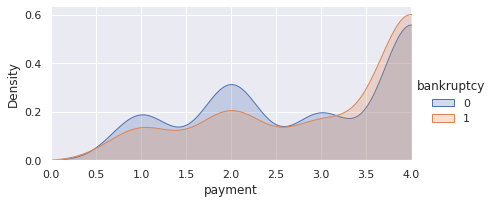

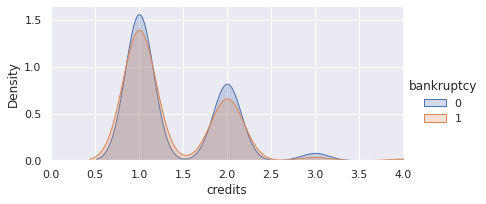

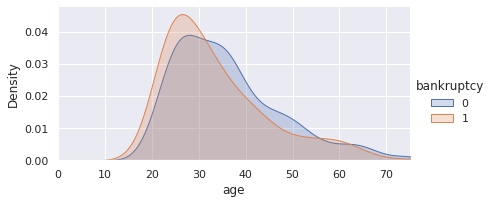

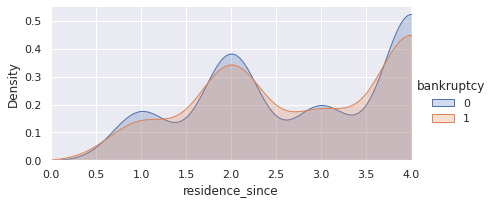

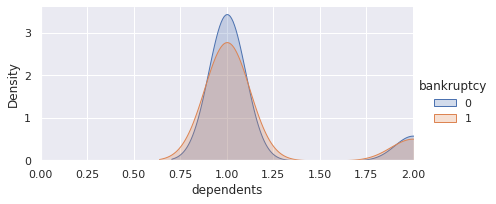

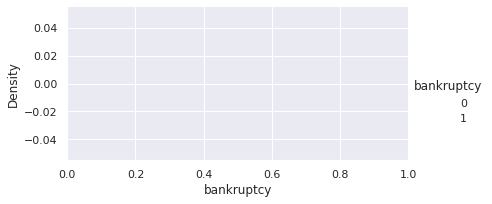

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [48]:
#Object以外の項目の分布図を縦に並べて表示
import seaborn as sns
import matplotlib.pyplot as plt

categories = train_df.columns[train_df.dtypes=='int64']

sns.set()
#fig, axes = plt.subplots(len(categories),1,figsize=(9,9*len(categories)))   

for i in range(len(categories)):
    fare = sns.FacetGrid(train_df, hue="bankruptcy",aspect=2)
    fare.map(sns.kdeplot,categories[i],shade= True)
    fare.set(xlim=(0, train_df[categories[i]].max()))
    fare.add_legend()
plt.show()


for j in range(len(categories)):
    print(train_df.groupby(categories[j]).count().index.to_list())


#**Data processing**

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# obtain object data type as list (outcomeが数値でないラベルを抜き出す)
categories = train_df.columns[train_df.dtypes=='object'].values.tolist()

# One-hot Encoding
for cat in categories:
    
    # generate Label Encoder object
    train_df_encoder = pd.get_dummies(train_df[[cat]])
    test_df_encoder = pd.get_dummies(test_df[[cat]])

    #concat 
    train_df = pd.concat([train_df, train_df_encoder],axis=1)
    test_df = pd.concat([test_df, test_df_encoder], axis=1)
    
    #drop original (object data) categories
    train_df.drop(cat, axis=1, inplace=True)
    test_df.drop(cat, axis=1, inplace=True)

#drop duplicated columns
train_df.loc[:,~train_df.columns.duplicated()]
test_df.loc[:,~test_df.columns.duplicated()]

In [ ]:
#Dataset

# target label
y = train_df['bankruptcy']

# predictor features
X = train_df.drop(['id', 'bankruptcy'], axis=1)

# list of categorical features
category_list = X.columns[X.dtypes=='category'].values.tolist()


In [ ]:
from pandas._libs.tslibs.parsing import try_parse_date_and_time
# LightGBM / hyper parameters
lgbm_params = {
    'boosting_type': 'gbdt',            # Gradient Boosting Decision Tree
    'objective': 'binary',                 # binary classification
    'metric': 'auc',                         # evaluator：AUC
    
    'learning_rate': 0.05, 
    
    'num_leaves': 32, 
    
    'n_estimators': 100000, 
    'importance_type': 'gain', 
    
    'random_state': 123, 
}

params = {
    'boosting_type': 'gbdt',            # Gradient Boosting Decision Tree
    'objective': 'binary',
    'verbose': -1,
    "metric" : "None",
        'learning_rate': 0.05, 
    'num_leaves': 32, 
    'n_estimators': 100000, 
    'importance_type': 'gain',  
    'random_state': 123, 
}

#custom_metrics
import sklearn
from sklearn.metrics import f1_score
import numpy as np
from sklearn import datasets
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import lightgbm as lgb
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
def f1(preds, data):
    y_true = data.get_label()
    y_pred = np.where(preds > 0.5, 1, 0)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    metric = 2*precision*recall/(precision+recall)
    return 'f1', metric, True

def accuracy(preds, data):
    """精度 (Accuracy) を計算する関数"""
    y_true = data.get_label()
    y_pred = np.where(preds > 0.5, 1, 0)
    metric = np.mean(y_true == y_pred)
    return 'accuracy', metric, True


def precision(preds, data):
    """適合率 (Precision) を計算する関数"""
    y_true = data.get_label()
    y_pred = np.where(preds > 0.5, 1, 0)
    metric = precision_score(y_true, y_pred)
    return 'precision', metric, True


def recall(preds, data):
    """再現率 (Recall) を計算する関数"""
    y_true = data.get_label()
    y_pred = np.where(preds > 0.5, 1, 0)
    metric = recall_score(y_true, y_pred)
    return 'recall', metric, True

def prroc(preds, data):
    """AUC を計算する関数"""
    y_true = data.get_label()
    y_pred = preds
    recall, precision, thresholds = precision_recall_curve(y_true, y_pred)
    metric = sklearn.metrics.auc(recall, precision)
    return 'prroc', metric, True

def aucroc(preds, data):
    """Precision_recall_AUC を計算する関数"""
    y_true = data.get_label()
    y_pred = preds
    metric = roc_auc_score(y_true, y_pred)
    return 'aucroc', metric, True


def metrics(preds, data): #複数onにすると、複数の指標でearly stoppingをしてしまうので注意
    """複数の評価指標を計算するための関数"""
    # リストでまとめて返せば良い
    return [
        #accuracy(preds, data),
        #precision(preds, data),
        #recall(preds, data),
        #f1(preds, data),
        aucroc(preds, data),
        #prroc(preds, data), #これはうまくいかない
    ]

#**PythonAPI_lightGBM**

In [ ]:
from sklearn.metrics import log_loss


# StratifiedKFold-CV

# num of fold
folds = 5

# list of fixed models based on CV
models = []

# list of auc based on CV
auc = []

# prediction of valid data
out_of_fold = np.zeros(len(X))


# generate StratifiedKFold object and prepare train_index & valid_index
cv = list(StratifiedKFold(n_splits=folds, shuffle=True, random_state=123).split(X, y))


# CV
for n_fold in np.arange(folds):
    
    # obtain index for model fitting
    train_index = cv[n_fold][0]
    
    # obtain index for validation data
    valid_index = cv[n_fold][1]
    
    # predictor features for model fitting
    x_train_cv = X.iloc[train_index]
    
    # target label for model fitting
    y_train_cv =y.iloc[train_index]
    
    # predictor features for validation
    x_valid_cv = X.iloc[valid_index]
    
    # target label for validation
    y_valid_cv = y.iloc[valid_index]
    
    # データセットを生成する
    lgb_train = lgb.Dataset(x_train_cv, y_train_cv)
    lgb_eval = lgb.Dataset(x_valid_cv, y_valid_cv, reference=lgb_train)

    # 上記のパラメータでモデルを学習する
    evals_result = {}
    model = lgb.train(params, lgb_train, 
                  #valid_sets=lgb_eval,
                  verbose_eval=50,  # 50イテレーション毎に学習結果出力
                  num_boost_round=1000,  # 最大イテレーション回数指定
                  early_stopping_rounds=50,
                  # メトリックを追跡する対象のデータセット
                  valid_sets=[lgb_eval, lgb_train],
                  #valid_sets=[lgb_eval],
                  # 上記の名前
                  valid_names=['eval', 'train'],
                  # メトリックの履歴を残すオブジェクト
                  evals_result=evals_result,
                  # 独自メトリックを計算する関数
                  feval=metrics,
                 )
    
    
    # predict data for model fitting
    y_pred_train = model.predict(x_train_cv)
    
    # predict validation data
    y_pred_valid = model.predict(x_valid_cv)
    
    
    # AUC
    # data for model fitting
    temp_auc_train = roc_auc_score(y_train_cv, y_pred_train)
    
    # validation data
    temp_auc_valid = roc_auc_score(y_valid_cv, y_pred_valid)

    #calculate log_loss
    logloss = log_loss(y_valid_cv, y_pred_valid)

    print(f'\nfold: {n_fold}')
    print(f'log loss: {logloss}')
    
    # AUC
    print(f'auc(train_data) = {temp_auc_train:.4f}')
    print(f'auc(valid_data) = {temp_auc_valid:.4f}\n\n')
    
    # AUC append
    auc.append([temp_auc_train, temp_auc_valid])
    
    # model append
    models.append(model)
    
    # prediction result of validation data
    out_of_fold[valid_index] = y_pred_valid

# auc into NumPy type
auc_np = np.array(auc)

# mean of auc (train data)
auc_train_mean = auc_np[:, 0].mean()
print(f'auc(train_data)_mean = {auc_train_mean:.4f}')

# mean of auc (validation data)
auc_valid_mean = auc_np[:, 1].mean()
print(f'auc(valid_data)_mean = {auc_valid_mean:.4f}')
    

#**SKlearn_lightGBM**

Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.978178	valid_1's auc: 0.724157
[100]	training's auc: 0.999209	valid_1's auc: 0.724722
[150]	training's auc: 1	valid_1's auc: 0.719827
Early stopping, best iteration is:
[75]	training's auc: 0.994443	valid_1's auc: 0.737714

auc(train_data) = 0.9944
auc(valid_data) = 0.7377

Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.972598	valid_1's auc: 0.816592
[100]	training's auc: 0.999021	valid_1's auc: 0.835751
[150]	training's auc: 1	valid_1's auc: 0.831101
Early stopping, best iteration is:
[86]	training's auc: 0.997271	valid_1's auc: 0.8391

auc(train_data) = 0.9973
auc(valid_data) = 0.8391

Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.980235	valid_1's auc: 0.747024
[100]	training's auc: 0.99909	valid_1's auc: 0.75465
[150]	training's auc: 1	valid_1's auc: 0.755952
[200]	training's auc: 1	valid_1's auc: 0.75372
Early stopping,

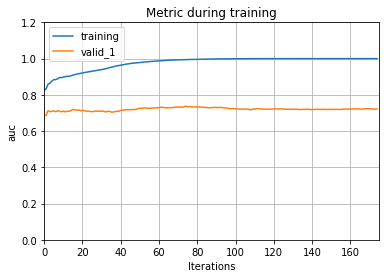

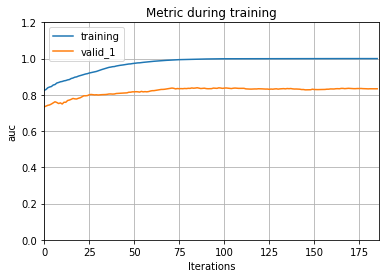

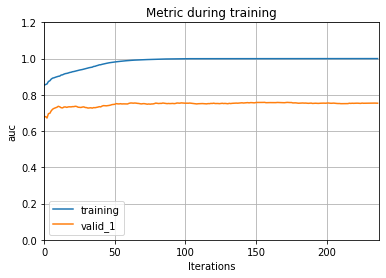

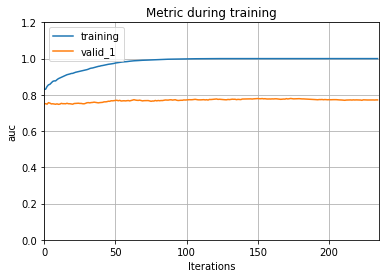

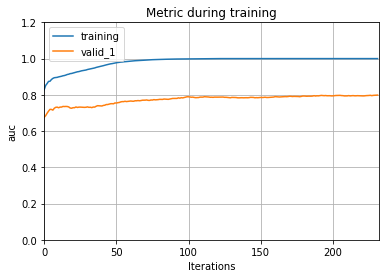

In [ ]:
# StratifiedKFold-CV

# num of fold
folds = 5

# list of fixed models based on CV
models = []

# list of auc based on CV
auc = []

# prediction of valid data
out_of_fold = np.zeros(len(X))


# generate StratifiedKFold object and prepare train_index & valid_index
cv = list(StratifiedKFold(n_splits=folds, shuffle=True, random_state=123).split(X, y))


# CV
for n_fold in np.arange(folds):
    
    # obtain index for model fitting
    train_index = cv[n_fold][0]
    
    # obtain index for validation data
    valid_index = cv[n_fold][1]
    
    # predictor features for model fitting
    x_train_cv = X.iloc[train_index]
    
    # target label for model fitting
    y_train_cv = y.iloc[train_index]
    
    # predictor features for validation
    x_valid_cv = X.iloc[valid_index]
    
    # target label for validation
    y_valid_cv = y.iloc[valid_index]
    
    
    
    # generate LightGBM model object
    model = lgb.LGBMClassifier(**lgbm_params)
    
    
    # model fitting
    model.fit(
        x_train_cv, 
        y_train_cv, 
        eval_set = [(x_train_cv, y_train_cv), (x_valid_cv, y_valid_cv)], 
        early_stopping_rounds = 100, 
        categorical_feature = category_list,
        verbose = 50, 
    )
    
    
    # predict data for model fitting
    y_pred_train = model.predict_proba(x_train_cv, num_iteration=model.best_iteration_)[:, 1]
    
    # predict validation data
    y_pred_valid = model.predict_proba(x_valid_cv, num_iteration=model.best_iteration_)[:, 1]
    
    
    # AUC
    # data for model fitting
    temp_auc_train = roc_auc_score(y_train_cv, y_pred_train)
    
    # validation data
    temp_auc_valid = roc_auc_score(y_valid_cv, y_pred_valid)
    
    # AUC
    print(f'\nauc(train_data) = {temp_auc_train:.4f}')
    print(f'auc(valid_data) = {temp_auc_valid:.4f}\n')
    
    # AUC append
    auc.append([temp_auc_train, temp_auc_valid])
    
    
    # model append
    models.append(model)
    
    # prediction result of validation data
    out_of_fold[valid_index] = y_pred_valid
    
    
    # plot of model fitting curve
    lgb.plot_metric(model, ylim=(0, 1.2));

In [ ]:
# auc into NumPy type
auc_np = np.array(auc)

# mean of auc (train data)
auc_train_mean = auc_np[:, 0].mean()
print(f'auc(train_data)_mean = {auc_train_mean:.4f}')

# mean of auc (validation data)
auc_valid_mean = auc_np[:, 1].mean()
print(f'auc(valid_data)_mean = {auc_valid_mean:.4f}')

auc(train_data)_mean = 0.9983
auc(valid_data)_mean = 0.7833


In [ ]:
# Prediction of test data

# list of prediction based on each CV
preds_test = []


# predictor features of test data
x_test = test_df.drop(['id'], axis=1)


# predict with learned model based on CV
for model in models:
    
    # predict
    pred = model.predict_proba(x_test, num_iteration=model.best_iteration_)[:, 1]
    
    # append
    preds_test.append(pred)

In [ ]:
# preds_test into NumPy type
preds_test_np = np.array(preds_test)

# obtain its mean
preds_test_np_mean = preds_test_np.mean(axis=0)

# print
preds_test_np_mean

In [ ]:
# obtain submission file from the prediction
submission['proba'] = preds_test_np_mean

submission

In [ ]:
# save submission
submission.to_csv('./submission.csv', index=False)

#**Specify important factors**

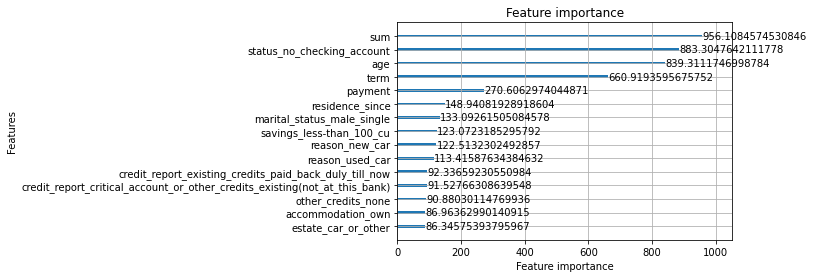

In [ ]:
# important features
lgb.plot_importance(model, importance_type='gain', max_num_features=15)